In [1]:
from shapely.geometry import box, Point, Polygon, LineString, MultiLineString
from shapely.affinity import scale, rotate
from shapely.ops import unary_union
import pickle
import pandas as pd
from datetime import datetime, timedelta

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm

import sys
import os
core_dir = os.path.join(os.getcwd(), '..', 'daphme')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)

import mobility_model as mmod
import stop_detection as sd

import pdb

# Definitions

In [2]:
class Building:
    def __init__(self, building_type, door, city, p_still, sigma, blocks=None, bbox=None):
        self.building_type = building_type
        self.door = door
        self.city = city

        self.p_still = p_still
        self.sigma = sigma

        self.id = f'{building_type[0]}-x{door[0]}-y{door[1]}'

        # Calculate the bounding box of the building
        if blocks:
            min_x = min([block[0] for block in blocks])
            min_y = min([block[1] for block in blocks])
            max_x = max([block[0]+1 for block in blocks])
            max_y = max([block[1]+1 for block in blocks])
            bbox = box(min_x, min_y, max_x, max_y)
        elif bbox:
            blocks = []
            for x in range(int(bbox.bounds[0]), int(bbox.bounds[2])):
                for y in range(int(bbox.bounds[1]), int(bbox.bounds[3])):
                    blocks += [(x, y)]
        else:
            raise ValueError(
                "Either blocks spanned or bounding box must be provided."
            )

        self.blocks = blocks
        self.geometry = bbox

        # Compute door centroid
        door = self.geometry.intersection(self.city.streets[self.door].geometry)
        self.door_centroid = ((door.coords[0][0] + door.coords[1][0]) / 2,
                              (door.coords[0][1] + door.coords[1][1]) / 2)


class Street:
    def __init__(self, coordinates):
        self.coordinates = coordinates
        self.neighbors_streets = []
        self.neighbors_buildings = []
        self.geometry = box(coordinates[0], coordinates[1],
                            coordinates[0]+1, coordinates[1]+1)

    def add_neighbor(self, neighbor):
        if neighbor is None or not check_adjacent(self.geometry, neighbor.geometry):
            return False
        if isinstance(neighbor, Street):
            self.neighbors_streets.append(neighbor)
            return True
        if isinstance(neighbor, Building) and neighbor.door == self.coordinates:
            self.neighbors_buildings.append(neighbor)
            return True
        return False


class City:
    def __init__(self, dimensions=(0, 0)):
        self.buildings = {}
        self.streets = {}
        self.buildings_outline = Polygon()
        self.address_book = {}

        # maybe at some point, p_still and sigma are inputs rather than hard coded
        self.p_still = {'park': 0.1,
                        'home': 0.6,
                        'work': 0.9,
                        'retail': 0.2}

        # controls "speed" of Brownian motion when simulating stay trajectory
        # The random variable X(t) of the position at time t has a normal
        # distribution with mean 0 and variance sigma^2 * t.
        # x/1.96 = 95% probability of moving x standard deviations
        self.sigma = {'park': 2.5/1.96,
                      'home': 1/1.96,
                      'work': 1/1.96,
                      'retail': 2/1.96}

        if not (isinstance(dimensions, tuple) and len(dimensions) == 2
                and all(isinstance(d, int) for d in dimensions)):
            raise ValueError("Dimensions must be a tuple of two integers.")
        self.city_boundary = box(0, 0, dimensions[0], dimensions[1])

        for x in range(0, dimensions[0]):
            for y in range(0, dimensions[1]):
                self.streets[(x, y)] = Street((x, y))
        self.dimensions = dimensions

    def add_building(self, building_type, door, blocks=None, bbox=None):
        building = Building(building_type, door, self,
                            self.p_still[building_type],
                            self.sigma[building_type],
                            blocks, bbox)

        combined_plot = unary_union([building.geometry, self.streets[door].geometry])
        if self.buildings_outline.contains(combined_plot) or self.buildings_outline.overlaps(combined_plot):
            raise ValueError(
                "New building or its door overlap with existing buildings."
            )

        if not check_adjacent(building.geometry, self.streets[door].geometry):
            raise ValueError(f"Door {door} must be adjacent to new building.")

        # add building
        self.buildings[building.id] = building
        self.buildings_outline = unary_union([self.buildings_outline, building.geometry])

        # blocks are no longer streets
        for block in building.blocks:
            self.address_book[block] = building
            del self.streets[block]

        # expand city boundary?
        buffered_building_geom = building.geometry.buffer(1)
        if not self.city_boundary.contains(buffered_building_geom):
            new_boundary = self.city_boundary.union(buffered_building_geom).envelope
            self.city_boundary = new_boundary
            self.dimensions = (int(new_boundary.bounds[2]), int(new_boundary.bounds[3]))
            # Update the streets for any new blocks within the expanded boundary
            minx, miny, maxx, maxy = map(int, new_boundary.bounds)
            for x in range(minx, maxx+1):
                for y in range(miny, maxy+1):
                    if (x, y) not in self.streets:
                        # Initialize new Street objects for the expanded city area
                        self.streets[(x, y)] = Street((x, y))

    def get_block(self, coordinates):
        # Return None if coordinates are outside the city
        x, y = coordinates
        bx, by = self.dimensions
        if (x < 0 or x >= bx or y < 0 or y >= bx):
            return None

        if coordinates in self.address_book:
            return self.address_book[coordinates]
        else:
            return self.streets[coordinates]

    # Determine adjacent streets and buildings for each street block and construct graph
    def get_street_graph(self):
        for x, y in self.streets.keys():
            street = self.streets[(x, y)]
            neighbors = [
                (x, y + 1),
                (x, y - 1),
                (x + 1, y),
                (x - 1, y)
            ]

            for neighbor in neighbors:
                block = self.get_block(neighbor)
                street.add_neighbor(block)

        # Construct graph of streets
        self.street_graph = {block: [] for block in self.streets.keys()}
        for street in self.street_graph.keys():
            self.street_graph[street] = [neighbor.coordinates for neighbor in
                                         self.get_block(street).neighbors_streets]

        # Compute shortest path between every pair of street coordinates
        self.shortest_paths = {street: {} for street in self.streets.keys()}
        for s_from in self.shortest_paths.keys():
            self.shortest_paths[s_from] = {street: [] for street in self.streets.keys()}
            for s_to in self.shortest_paths[s_from].keys():
                path = BFS_shortest_path(graph=self.street_graph, start=s_from, end=s_to)
                self.shortest_paths[s_from][s_to] = path

    def save(self, filename):
        """Save the city object to a file."""
        with open(filename, 'wb') as file:
            pickle.dump(self, file)

    def plot_city(self, ax, doors=True, address=True, zorder=1):
        # Draw city boundary
        x, y = self.city_boundary.exterior.xy
        ax.plot(np.array(x), np.array(y), linewidth=2, color='black')  # Dashed line for the boundary

        # Define colors for different building types
        colors = {
            'home': 'skyblue',
            'work': '#C9A0DC',
            'retail': 'lightgrey',
            'park': 'lightgreen'
        }

        # Draw buildings
        for building in self.buildings.values():
            x, y = building.geometry.exterior.xy
            ax.fill(x, y, facecolor=colors[building.building_type],
                    edgecolor='black', linewidth=0.5,
                    label=building.building_type.capitalize(), zorder=zorder)

            # Plot doors
            if doors:
                door_line = building.geometry.intersection(self.streets[building.door].geometry)
                scaled_door_line = scale(door_line, xfact=0.25, yfact=0.25, origin=door_line.centroid)
                dx, dy = scaled_door_line.xy
                ax.plot(dx, dy, linewidth=2, color='white', zorder=zorder)

#             if address:
#                 door_coord = building.door

#                 bbox = ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
#                 axes_width_in_inches = bbox.width
#                 axes_data_range = ax.get_xlim()[1] - ax.get_xlim()[0]
#                 fontsize = (axes_width_in_inches / axes_data_range) * 13  # Example scaling factor

#                 ax.text(door_coord[0] + 0.15, door_coord[1] + 0.15,
#                         f"{door_coord[0]}, {door_coord[1]}",
#                         ha='left', va='bottom',
#                         fontsize=fontsize, color='black')

        ax.set_aspect('equal')
        # Set integer ticks
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))


def load(filename):
    """Load a city object from a file."""
    with open(filename, 'rb') as file:
        return pickle.load(file)


def save(city, filename):
    """Save the city object to a file."""
    with open(filename, 'wb') as file:
        pickle.dump(city, file)


def check_adjacent(geom1, geom2):
    intersection = geom1.intersection(geom2)
    return isinstance(intersection, (LineString, MultiLineString))


def BFS_shortest_path(graph, start, end):
    """
    Computes the shortest path between a start and end street block.

    Parameters
    ---------
    graph: dict
        undirected graph with streets as vectices and edges between adjacent streets
    start: tuple
        coordinates of starting street (i.e., door of start building)
    end: tuple
        coordinates of ending street (i.e., door of end building)

    Returns
    -------
    A list denoting the shortest path of street blocks going from the start to the end.
    """
    
    # is this the most efficient way to do this? maybe Dijkstra's algorithm

    explored = []
    queue = [[start]]

    if start == end:
        return [start]

    while queue:
        path = queue.pop(0)
        node = path[-1]

        if node not in explored:
            neighbors = graph[node]

            for neighbor in neighbors:
                new_path = list(path)
                new_path.append(neighbor)
                queue.append(new_path)

                if neighbor == end:
                    return new_path
            explored.append(node)

    print("Path does not exist.")
    return None

In [111]:
class Agent:
    def __init__(self, identifier, home, workplace, city, destination_diary=None, transitions=None, trajectory=None, diary=None):
        """
        Parameters
        ---------
        identifier: string
            name of agent
        home: string building_id
        workplace: string building_id
        city: City
        destination_diary: pandas.DataFrame
            dataframe with columns 'unix_timestamp', 'local_timestamp', 'duration', 'location'
        trajectory: pandas.DataFrame
            dataframe with columns 'x', 'y', 'local_timestamp', 'unix_timestamp', 'identifier'
        diary: pandas.DataFrame
            dataframe with columns 'unix_timestamp', 'local_timestamp', 'duration', 'location'
        """

        self.identifier = identifier
        self.home = home
        self.workplace = workplace
        self.city = city
        self.destination_diary = pd.DataFrame(
                columns=['unix_timestamp', 'local_timestamp', 'duration', 'location'])
        self.transitions = transitions

        if (trajectory is None and diary is not None) or (trajectory is not None and diary is None):
            raise ValueError(
                "Either both trajectory and diary must be provided, or neither should be provided."
            )

        if trajectory is not None and diary is not None:
            self.trajectory = trajectory
            self.diary = diary # diary_from_trajectory ?
            if destination_diary is not None:
                self.destination_diary = destination_diary

        else:
            self.diary = pd.DataFrame(
                columns=['unix_timestamp', 'local_timestamp', 'duration', 'location'])

            if destination_diary is not None:
                self.destination_diary = destination_diary
            else:
                local_timestamp = datetime(2024, 1, 1, hour=8, minute=0)
                unix_timestamp = int(local_timestamp.timestamp())
                duration = 0  # TODO: don't hard code
                location = self.home
                entry = {'unix_timestamp': unix_timestamp,
                         'local_timestamp': local_timestamp,
                         'duration': duration,
                         'location': location}
                entry = pd.DataFrame([entry])
                self.destination_diary = pd.concat([self.destination_diary, entry], ignore_index=True)

            start_location = self.city.buildings[self.destination_diary.location.iloc[0]]
            start_coords = start_location.door_centroid
            unix_timestamp = self.destination_diary.unix_timestamp.iloc[0]
            local_timestamp = pd.to_datetime(unix_timestamp, unit='s')
            identifier = self.identifier
            ping = [[start_coords[0], start_coords[1], local_timestamp, unix_timestamp, identifier]]
            self.trajectory = pd.DataFrame(ping, 
                columns=['x', 'y', 'local_timestamp', 'unix_timestamp', 'identifier'])

    def plot_traj(self, ax, color='black', alpha=1, doors=True, address=True):
        ax.scatter(self.trajectory.x, self.trajectory.y, s=6, color=color, alpha=alpha, zorder=2)
        self.city.plot_city(ax, doors=doors, address=address, zorder=1)


def ortho_coord(multilines, distance, offset, eps=0.001):  # Calculus approach. Probably super slow.
    point = multilines.interpolate(distance)
    offset_point = multilines.interpolate(distance - eps)
    angle = 90 if offset < 0 else -90
    ortho_direction = rotate(offset_point, angle, origin=point)
    ortho_segment = LineString([point, ortho_direction])
    scaled_segment = scale(
        ortho_segment, xfact=offset / ortho_segment.length,
        yfact=offset / ortho_segment.length, origin=point)
    return scaled_segment.coords[1]


def condense_destinations(destination_diary):  # This might be a more general clustering algorithm
    """
    Modifies a sequence of timestamped destinations, joining consecutive 
    destinations in the same location into a single entry with the aggregated duration.

    Parameters
    ----------
    destination_diary : DataFrame
        DataFrame containing timestamped locations the user is heading towards.

    Returns
    -------
    DataFrame
        A new DataFrame with condensed destination entries.
    """
    if destination_diary.empty:
        return pd.DataFrame()

    # Detect changes in location
    destination_diary['new_segment'] = destination_diary['location'].ne(destination_diary['location'].shift())

    # Create segment identifiers for grouping
    destination_diary['segment_id'] = destination_diary['new_segment'].cumsum()

    # Aggregate data by segment
    condensed_df = destination_diary.groupby('segment_id').agg({
        'unix_timestamp': 'first',
        'local_timestamp': 'first',
        'duration': 'sum',
        'location': 'first'
    }).reset_index(drop=True)

    return condensed_df


class Population:
    def __init__(self, city):
        self.roster = {}
        self.city = city

    def add_agent(self, agent):
        if agent.identifier in self.roster:
            print("Agent identifier already exists in population. Replacing corresponding agent.")
        self.roster[agent.identifier] = agent

    def generate_agents(self, N):
        """
        Generates N agents, each with a house and workplace sampled uniformly at random.
        """
        b_types = pd.DataFrame({
            'id': list(city.buildings.keys()),
            'type': [b.building_type for b in city.buildings.values()]
        }).set_index('id')

        homes = b_types[b_types['type'] == 'home'].index
        workplaces = b_types[b_types['type'] == 'work'].index
        sampled_homes = npr.choice(homes, N, replace=True)
        sampled_workplaces = npr.choice(workplaces, N, replace=True)
        identifiers = [f"Agent{x}" for x in range(N)]  # could run into an issue of replacing existing agents if called multiple times

        properties = list(zip(identifiers, sampled_homes, sampled_workplaces))

        for i in range(N):
            agent = Agent(*properties[i], self.city)
            self.add_agent(agent)

    def sample_step(self, start_point, dest_building, dt):
        """
        TO DO

        Parameters
        ---------
        start_point: tuple
            the coordinates of the current position
        dest_building: Building
            the destination building of the agent
        dt: float
            time step (i.e., number of minutes per ping)

        Returns
        -------
        coord: numpy array of floats with shape (1,2).
        location: building id if step is a stay or None is step is a move
        """
        city = self.city

        # Find current geometry
        start_block = np.floor(start_point)  # blocks are indexed by bottom left
        start_geometry = city.get_block(tuple(start_block))

        curr = np.array(start_point)

        # Agent moves within the building
        if start_geometry == dest_building or start_point == dest_building.door_centroid:
            location = dest_building.id
            p = dest_building.p_still      # probability of staying still
            sigma = dest_building.sigma    # "speed" of Brownian motion

            if npr.uniform()<p:
                coord = curr
            else:

                # Draw until coord falls inside building
                while True:
                    coord = np.random.normal(loc=curr, scale=sigma*np.sqrt(dt), size=2)
                    if dest_building.geometry.contains(Point(coord)):
                        break

        # Agent travels to building along the streets
        else:
            location = None
            dest_point = dest_building.door

            if start_geometry in city.buildings.values():
                start_segment = [start_point, start_geometry.door_centroid]
                start = start_geometry.door
            else:
                start_segment = []
                start = tuple(start_block.astype(int))

            street_path = city.shortest_paths[start][dest_point]
            path = [(x+0.5, y+0.5) for x,y in street_path]
            path = start_segment + path + [dest_building.door_centroid]
            path_ml = MultiLineString([path])

            # Bounding polygon
            street_poly = unary_union([city.get_block(block).geometry for block in street_path])

            bound_poly = unary_union([start_geometry.geometry, street_poly])
            # Snap to path
            snap_point_dist = path_ml.project(Point(start_point))

            delta = 3.33*dt      # 50m/min; blocks are 15m x 15m
            sigma = 0.5*dt/1.96  # 95% prob of moving 0.5

            # Draw until coord falls inside bound_poly
            while True:
                # consider a "path" coordinate and "orthogonal coordinate"
                transformed_step = np.random.normal(loc=[delta, 0], scale=sigma*np.sqrt(dt), size=2)

                if snap_point_dist + transformed_step[0] > path_ml.length:
                    coord = np.array(dest_building.door_centroid)
                    break
                else:
                    coord = ortho_coord(path_ml, snap_point_dist+transformed_step[0], transformed_step[1])
                    if bound_poly.contains(Point(coord)):
                        break

        return coord, location

    def traj_from_dest_diary(self, agent, dt):
        """
        Simulate a trajectory and calculate true travel diary.

        Parameters
        ----------
        agent: Agent

        Returns
        -------
        None (updates agent.trajectory, agent.diary)
        """

        city = self.city

        destination_diary = agent.destination_diary
        for i in range(destination_diary.shape[0]):
            destination_info = destination_diary.iloc[i]
            duration = int(destination_info['duration'] * 1/dt)
            building_id = destination_info['location']
            for t in range(duration):
                prev_ping = agent.trajectory.iloc[-1]

                start_point = (prev_ping['x'], prev_ping['y'])
                dest_building = city.buildings[building_id]
                coord, location = self.sample_step(start_point, dest_building, dt)

                unix_timestamp = prev_ping['unix_timestamp'] + 60*dt
                local_timestamp = pd.to_datetime(unix_timestamp, unit='s')
                ping = {'x': coord[0], 'y': coord[1],
                        'local_timestamp': local_timestamp,
                        'unix_timestamp': unix_timestamp,
                        'identifier': agent.identifier}
                ping = pd.DataFrame([ping])
                agent.trajectory = pd.concat([agent.trajectory, ping],
                                             ignore_index=True)

                if agent.diary.empty or agent.diary.iloc[-1]['location'] != location:
                    entry = {'unix_timestamp': unix_timestamp,
                             'local_timestamp': local_timestamp,
                             'duration': dt,
                             'location': location}
                    entry = pd.DataFrame([entry])
                    agent.diary = pd.concat([agent.diary, entry],
                                            ignore_index=True)
                else:
                    agent.diary.loc[agent.diary.shape[0]-1, 'duration'] += 1*dt

        # empty the destination diary
        agent.destination_diary = destination_diary.drop(destination_diary.index)

    def generate_transition_probs(self, agent, location, building_choices):
        N = len(building_choices)
        probs = [1] * N
        idx = building_choices.index[building_choices.id == location][0]
        probs[idx] = N-1
        probs = [p / sum(probs) for p in probs]  # normalize probabilities
        return probs

    def dest_diary_from_trans(self, agent, T, duration=15, dt=1, trans=None):
        """
        Simulate a destination diary from transition matrices

        Parameters
        ----------
        agent: Agent
        T: int
            how many entries to generate
        duration: int
            how long each entry is (total duration is duration * T)

        Returns
        -------
        updates destination diary of agent
        """
        city = self.city
        pr_weight = 4

        # Ensure building IDs are the index
        b_types = pd.DataFrame({
            'id': list(city.buildings.keys()),
            'type': [b.building_type for b in city.buildings.values()]
        }).set_index('id')

        N = len(b_types)
        trans = pd.DataFrame(np.ones((N, N)), index=b_types.index, columns=b_types.index)

        trans[agent.home] += pr_weight
        trans[agent.workplace] += pr_weight

        np.fill_diagonal(trans.values, N + pr_weight)

        # Correct allowed_buildings function
        def allowed_buildings(ts, b_types):
            hour = ts.hour
            if 0 <= hour < 8 or 20 <= hour < 24:
                return b_types[b_types['type'] == 'home'].index
            elif 8 <= hour < 9:
                return b_types[b_types['type'] != 'home'].index
            elif 9 <= hour < 12 or 13.5 <= hour < 17.5:
                return b_types[b_types['type'] == 'work'].index
            elif 12 <= hour < 13.5:
                return b_types[b_types['type'] == 'retail'].index
            elif 17.5 <= hour < 20:
                return b_types[b_types['type'] != 'work'].index
            return b_types[b_types['type'] == 'home'].index

        last_entry = (agent.destination_diary.iloc[-1] if not agent.destination_diary.empty else agent.diary.iloc[-1])
        cur_loc = last_entry.location
        next_ts = last_entry.local_timestamp + timedelta(minutes=int(last_entry.duration))

        new_entries = []

        for _ in range(T):
            unix_ts = int(next_ts.timestamp())

            allowed_indices = allowed_buildings(next_ts, b_types)
            trans_probs = trans.loc[cur_loc, allowed_indices]
            trans_probs = trans_probs / trans_probs.sum()

            cur_loc = npr.choice(trans_probs.index, p=trans_probs.values)

            entry = {'unix_timestamp': unix_ts,
                     'local_timestamp': next_ts,
                     'duration': duration,
                     'location': cur_loc}

            new_entries.append(entry)
            next_ts += timedelta(minutes=duration)

        new_entries_df = pd.DataFrame(new_entries)
        agent.destination_diary = pd.concat([agent.destination_diary, new_entries_df], ignore_index=True)

        agent.destination_diary = condense_destinations(agent.destination_diary)

    def generate_trajectory(self, agent, T=None, duration=15, seed=None, dt=1):

        if seed:
            npr.seed(seed)
        else:
            seed = npr.randint(0, 1000, 1)[0]
            npr.seed(seed)
            print("Seed:", seed)

        if agent.destination_diary.empty:
            raise ValueError(
                    "Destination diary is empty. Provide a parameter T to generate destination diary from transition matrix."
                )
        if T is not None:
            self.dest_diary_from_trans(agent, T, duration=duration, dt=dt, trans=agent.transitions)

        self.traj_from_dest_diary(agent, dt)

    def plot_population(self, ax, doors=True, address=True):
        for i, agent_id in enumerate(self.roster):
            agent = self.roster[agent_id]
            col = cm.tab20c(i/len(self.roster))
            ax.scatter(agent.trajectory.x, agent.trajectory.y, s=6, color=col, alpha=1, zorder=2)
        self.city.plot_city(ax, doors=doors, address=address, zorder=1)

# Initialize city

In [5]:
# # Initialize city
# city = City(dimensions=(22, 22))

# # add park
# city.add_building('park', (13, 11), bbox=box(9, 9, 13, 13))

# # add homes
# city.add_building('home', (8, 8), [(7, 7), (7, 8)])
# city.add_building('home', (9, 8), [(8, 7), (9, 7)])
# city.add_building('home', (10, 8), [(10, 7)])
# city.add_building('home', (11, 8), [(11, 7)])
# city.add_building('home', (13, 6), [(13, 7)])
# city.add_building('home', (14, 6), [(14, 7)])
# city.add_building('home', (13, 8), [(14, 8)])
# city.add_building('home', (13, 9), [(14, 9)])
# city.add_building('home', (13, 11), [(14, 11)])
# city.add_building('home', (13, 12), [(14, 12)])
# city.add_building('home', (15, 13), [(14, 13)])
# city.add_building('home', (13, 13), [(13, 14), (14, 14)])
# city.add_building('home', (12, 13), [(12, 14)])
# city.add_building('home', (11, 13), [(11, 14)])
# city.add_building('home', (9, 13), [(9, 14)])
# city.add_building('home', (8, 13), [(8, 14)])
# city.add_building('home', (7, 15), [(7, 14)])
# city.add_building('home', (6, 13), [(7, 13)])
# city.add_building('home', (8, 12), [(7, 12)])
# city.add_building('home', (8, 10), [(7, 10), (7, 9)])

# # add workplaces
# city.add_building('work', (3, 4), [(4, 4), (4, 5)])
# city.add_building('work', (5, 3), [(5, 4), (5, 5)])
# city.add_building('work', (6, 6), bbox=box(6, 4, 8, 6))
# city.add_building('work', (8, 6), bbox=box(8, 4, 10, 6))
# city.add_building('work', (12, 6), bbox=box(11, 5, 14, 6))
# city.add_building('work', (12, 3), bbox=box(11, 4, 14, 5))
# city.add_building('work', (15, 3), bbox=box(14, 4, 17, 6))
# city.add_building('work', (18, 4), bbox=box(17, 4, 18, 6))
# city.add_building('work', (18, 6), bbox=box(16, 6, 18, 8))
# city.add_building('work', (15, 9), bbox=box(16, 8, 17, 10))
# city.add_building('work', (18, 8), bbox=box(17, 8, 18, 10))
# city.add_building('work', (18, 10), bbox=box(16, 10, 18, 12))
# city.add_building('work', (18, 13), bbox=box(16, 13, 18, 15))
# city.add_building('work', (18, 15), bbox=box(16, 15, 18, 16))
# city.add_building('work', (15, 15), bbox=box(15, 16, 18, 17))
# city.add_building('work', (14, 15), [(14, 16)])
# city.add_building('work', (16, 18), bbox=box(16, 17, 18, 18))
# city.add_building('work', (15, 18), bbox=box(14, 17, 16, 18))
# city.add_building('work', (13, 18), bbox=box(12, 16, 14, 18))
# city.add_building('work', (11, 18), bbox=box(10, 17, 12, 18))
# city.add_building('work', (11, 15), bbox=box(10, 16, 12, 17))
# city.add_building('work', (8, 18), bbox=box(7, 16, 9, 18))
# city.add_building('work', (6, 18), bbox=box(5, 17, 7, 18))
# city.add_building('work', (6, 15), bbox=box(5, 16, 7, 17))
# city.add_building('work', (3, 16), [(4, 16), (4, 17)])
# city.add_building('work', (3, 13), bbox=box(4, 13, 6, 16))
# city.add_building('work', (6, 12), bbox=box(4, 12, 6, 13))
# city.add_building('work', (3, 10), [(4, 9), (4, 10)])
# city.add_building('work', (6, 9), [(5, 9), (5, 10)])
# city.add_building('work', (6, 8), [(4, 8), (5, 8)])
# city.add_building('work', (3, 6), bbox=box(4, 6, 6, 8))

# # add retail
# city.add_building('retail', (0, 1), bbox=box(1, 1, 3, 3))
# city.add_building('retail', (3, 0), bbox=box(3, 1, 5, 3))
# city.add_building('retail', (5, 0), [(5, 1)])
# city.add_building('retail', (5, 3), [(5, 2)])
# city.add_building('retail', (6, 0), bbox=box(6, 1, 8, 2))
# city.add_building('retail', (6, 3), bbox=box(6, 2, 8, 3))
# city.add_building('retail', (9, 3), bbox=box(9, 1, 10, 3))
# city.add_building('retail', (12, 3), bbox=box(10, 1, 13, 3))
# city.add_building('retail', (14, 3), bbox=box(13, 1, 15, 3))
# city.add_building('retail', (15, 3), [(15, 2)])
# city.add_building('retail', (16, 3), [(16, 2)])
# city.add_building('retail', (15, 0), [(15, 1)])
# city.add_building('retail', (16, 0), [(16, 1)])
# city.add_building('retail', (17, 3), bbox=box(17, 2, 19, 3))
# city.add_building('retail', (18, 0), bbox=box(17, 1, 19, 2))
# city.add_building('retail', (19, 0), bbox=box(19, 1, 21, 2))
# city.add_building('retail', (18, 3), bbox=box(19, 2, 21, 4))
# city.add_building('retail', (18, 5), bbox=box(19, 4, 21, 6))
# city.add_building('retail', (18, 7), bbox=box(19, 6, 20, 8))
# city.add_building('retail', (21, 7), bbox=box(20, 6, 21, 8))
# city.add_building('retail', (18, 10), bbox=box(19, 9, 21, 11))
# city.add_building('retail', (18, 11), bbox=box(19, 11, 21, 13))
# city.add_building('retail', (18, 13), bbox=box(19, 13, 20, 15))
# city.add_building('retail', (21, 13), bbox=box(20, 13, 21, 15))
# city.add_building('retail', (21, 16), bbox=box(19, 15, 21, 17))
# city.add_building('retail', (21, 18), bbox=box(19, 17, 21, 19))

# city.add_building('retail', (21, 19), bbox=box(19, 19, 21, 20))
# city.add_building('retail', (20, 21), bbox=box(19, 20, 21, 21))
# city.add_building('retail', (17, 18), bbox=box(17, 19, 18, 21))
# city.add_building('retail', (16, 18), bbox=box(16, 19, 17, 21))
# city.add_building('retail', (14, 18), bbox=box(13, 19, 16, 20))
# city.add_building('retail', (15, 21), bbox=box(14, 20, 16, 21))
# city.add_building('retail', (13, 21), bbox=box(12, 20, 14, 21))
# city.add_building('retail', (12, 18), bbox=box(12, 19, 13, 20))
# city.add_building('retail', (11, 18), bbox=box(10, 19, 12, 21))
# city.add_building('retail', (9, 18), bbox=box(8, 19, 10, 20))
# city.add_building('retail', (9, 21), bbox=box(8, 20, 10, 21))
# city.add_building('retail', (6, 21), bbox=box(5, 19, 7, 21))
# city.add_building('retail', (4, 21), bbox=box(3, 20, 5, 21))
# city.add_building('retail', (4, 18), bbox=box(3, 19, 5, 20))
# city.add_building('retail', (2, 18), bbox=box(2, 19, 3, 21))
# city.add_building('retail', (1, 18), bbox=box(1, 19, 2, 21))
# city.add_building('retail', (3, 17), bbox=box(1, 16, 3, 18))
# city.add_building('retail', (3, 15), bbox=box(1, 15, 3, 16))
# city.add_building('retail', (3, 14), bbox=box(1, 14, 3, 15))
# city.add_building('retail', (3, 12), bbox=box(1, 12, 3, 14))
# city.add_building('retail', (3, 11), bbox=box(1, 11, 3, 12))
# city.add_building('retail', (3, 10), bbox=box(1, 10, 3, 11))
# city.add_building('retail', (3, 8), bbox=box(1, 8, 3, 10))
# city.add_building('retail', (3, 7), bbox=box(1, 7, 3, 8))
# city.add_building('retail', (0, 5), bbox=box(1, 4, 2, 7))
# city.add_building('retail', (3, 6), [(2, 6)])
# city.add_building('retail', (3, 5), [(2, 5)])
# city.add_building('retail', (3, 4), [(2, 4)])

# city.get_street_graph()
# city.save('garden-city.pkl')

In [112]:
city = load('garden-city.pkl')
population = Population(city)

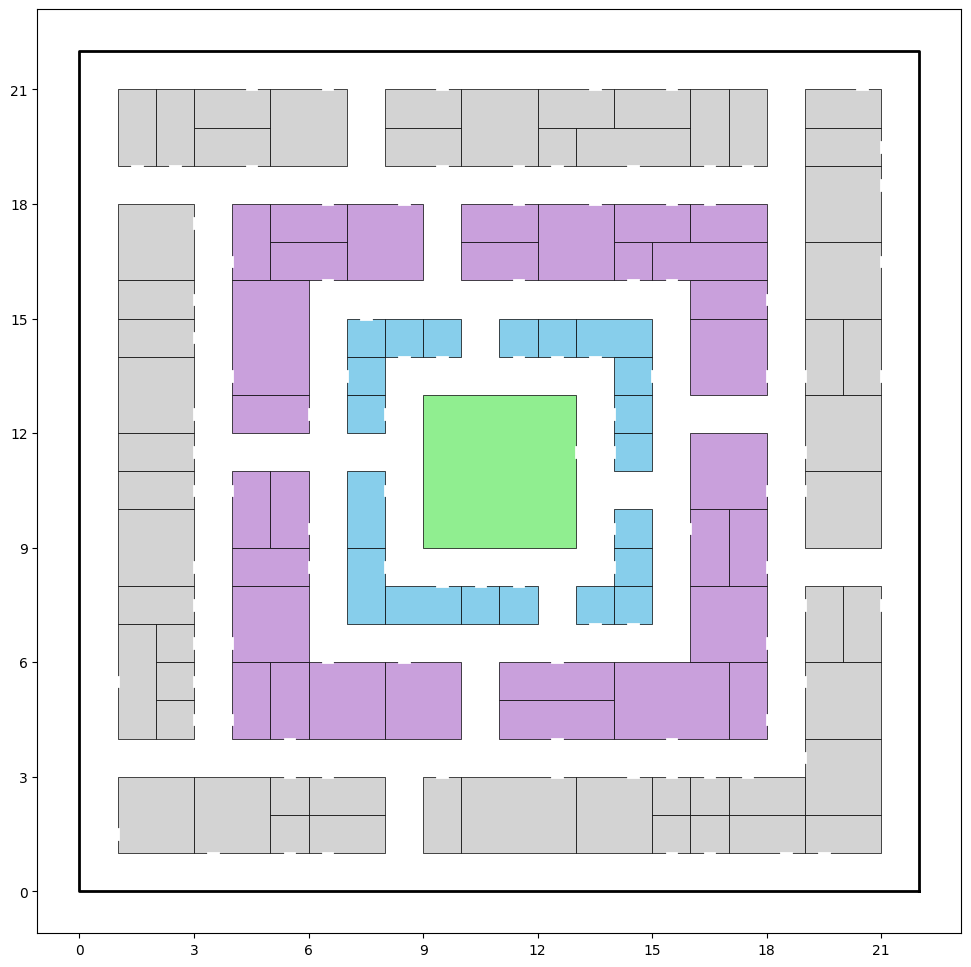

In [7]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 12))
city.plot_city(ax, doors=True, address=True)

In [8]:
# identify a building by its door coordinates and building type
print(city.buildings['r-x12-y3'].blocks)
city.buildings['r-x12-y3'].door_centroid

[(10, 1), (10, 2), (11, 1), (11, 2), (12, 1), (12, 2)]


(12.5, 3.0)

# Trajectory Simulation

In [113]:
start_time = [datetime(2000, 1, 1, hour=0, minute=0) + timedelta(minutes=15*t) for t in range(22)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [15]*22  # in minutes
location = ['h-x8-y13',
            'h-x8-y13',
            'r-x12-y3',
            'r-x12-y3',
            'r-x12-y3',
            'r-x12-y3',
            'w-x15-y15',
            'w-x15-y15',
            'w-x15-y15',
            'w-x15-y15',
            'w-x15-y15',
            'w-x15-y15',
            'w-x15-y15',
            'w-x15-y15',
            'w-x15-y15',
            'w-x15-y15',
            'w-x15-y15',
            'w-x15-y15',
            'h-x8-y13',
            'h-x8-y13',
            'h-x8-y13',
            'h-x8-y13']

destination = pd.DataFrame({"unix_timestamp":unix_timestamp, "local_timestamp":start_time, "duration":duration, "location":location})
destination = condense_destinations(destination)

# attributes of class Population with Agents (with location sequence and trajectory)
# City has attributes sigma, p (associated with each Building type), maybe larger sigma for streets if we end up doing that

Duncan = Agent("Duncan",
               'h-x8-y13',
               'w-x15-y15',
               city,
               destination_diary=destination)

population.add_agent(Duncan)
population.generate_trajectory(Duncan, seed=100)

# print(Duncan.diary)
Duncan.trajectory

,x,y,local_timestamp,unix_timestamp,identifier
0,8.500000,14.000000,2000-01-01 00:00:00,946684800,Duncan
1,8.500000,14.000000,2000-01-01 00:01:00,946684860,Duncan
2,8.500000,14.000000,2000-01-01 00:02:00,946684920,Duncan
3,8.500000,14.000000,2000-01-01 00:03:00,946684980,Duncan
4,8.403318,14.130103,2000-01-01 00:04:00,946685040,Duncan
...,...,...,...,...,...
326,8.806690,14.316536,2000-01-01 05:26:00,946704360,Duncan
327,8.383411,14.908611,2000-01-01 05:27:00,946704420,Duncan
328,8.383411,14.908611,2000-01-01 05:28:00,946704480,Duncan
329,8.383411,14.908611,2000-01-01 05:29:00,946704540,Duncan


In [114]:
population.dest_diary_from_trans(Duncan, 70)
Duncan.destination_diary

,unix_timestamp,local_timestamp,duration,location
0,946704660,2000-01-01 05:31:00,135,h-x8-y13
1,946712760,2000-01-01 07:46:00,15,h-x13-y6
2,946713660,2000-01-01 08:01:00,15,r-x18-y5
3,946714560,2000-01-01 08:16:00,30,w-x12-y6
4,946716360,2000-01-01 08:46:00,15,r-x3-y14
5,946717260,2000-01-01 09:01:00,30,w-x18-y4
6,946719060,2000-01-01 09:31:00,30,w-x18-y6
7,946720860,2000-01-01 10:01:00,15,w-x8-y6
8,946721760,2000-01-01 10:16:00,30,w-x3-y16
9,946723560,2000-01-01 10:46:00,15,w-x6-y18


In [115]:
Thomas = Agent("Thomas", 
               'h-x8-y8',
               'w-x18-y4',
               city)

population.add_agent(Thomas)
population.generate_trajectory(Thomas, T=40, seed=100)
Thomas.trajectory

,x,y,local_timestamp,unix_timestamp,identifier
0,8.000000,8.500000,2024-01-01 08:00:00,1704096000,Thomas
1,12.016480,8.847336,2024-01-01 08:01:00,1704096060,Thomas
2,11.253224,6.485797,2024-01-01 08:02:00,1704096120,Thomas
3,10.868168,3.866489,2024-01-01 08:03:00,1704096180,Thomas
4,8.708279,2.362947,2024-01-01 08:04:00,1704096240,Thomas
...,...,...,...,...,...
596,14.296375,16.604893,2024-01-01 17:56:00,1704131760,Thomas
597,14.240774,16.742796,2024-01-01 17:57:00,1704131820,Thomas
598,14.240774,16.742796,2024-01-01 17:58:00,1704131880,Thomas
599,14.240774,16.742796,2024-01-01 17:59:00,1704131940,Thomas


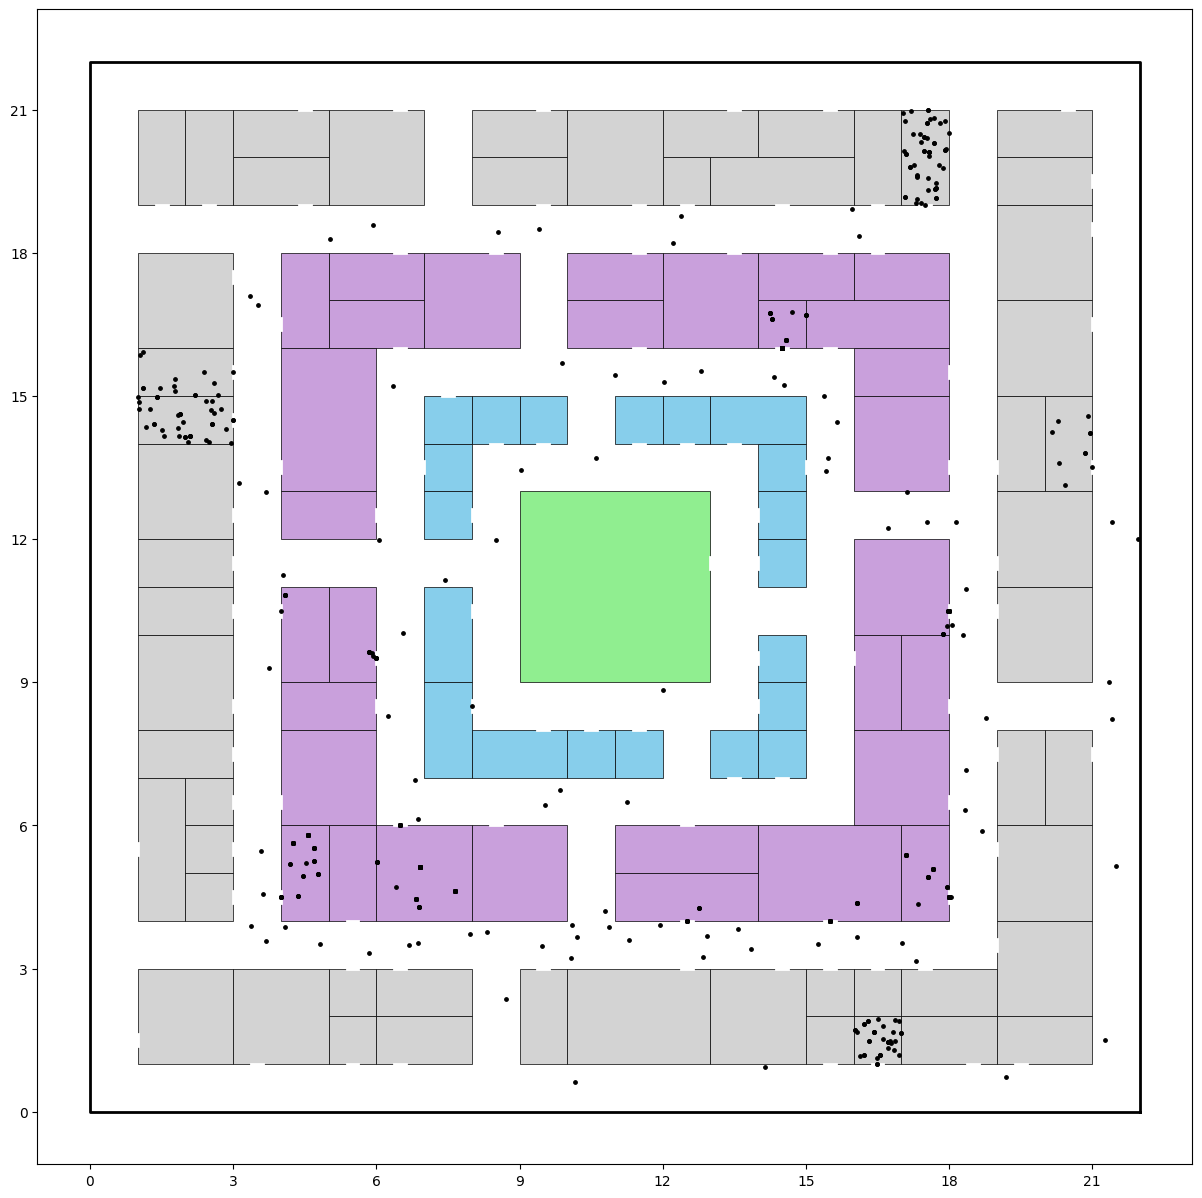

In [118]:
fig, ax = plt.subplots(figsize=(15, 15))
Thomas.plot_traj(ax)

#plt.savefig("garden-city-one-user.png")

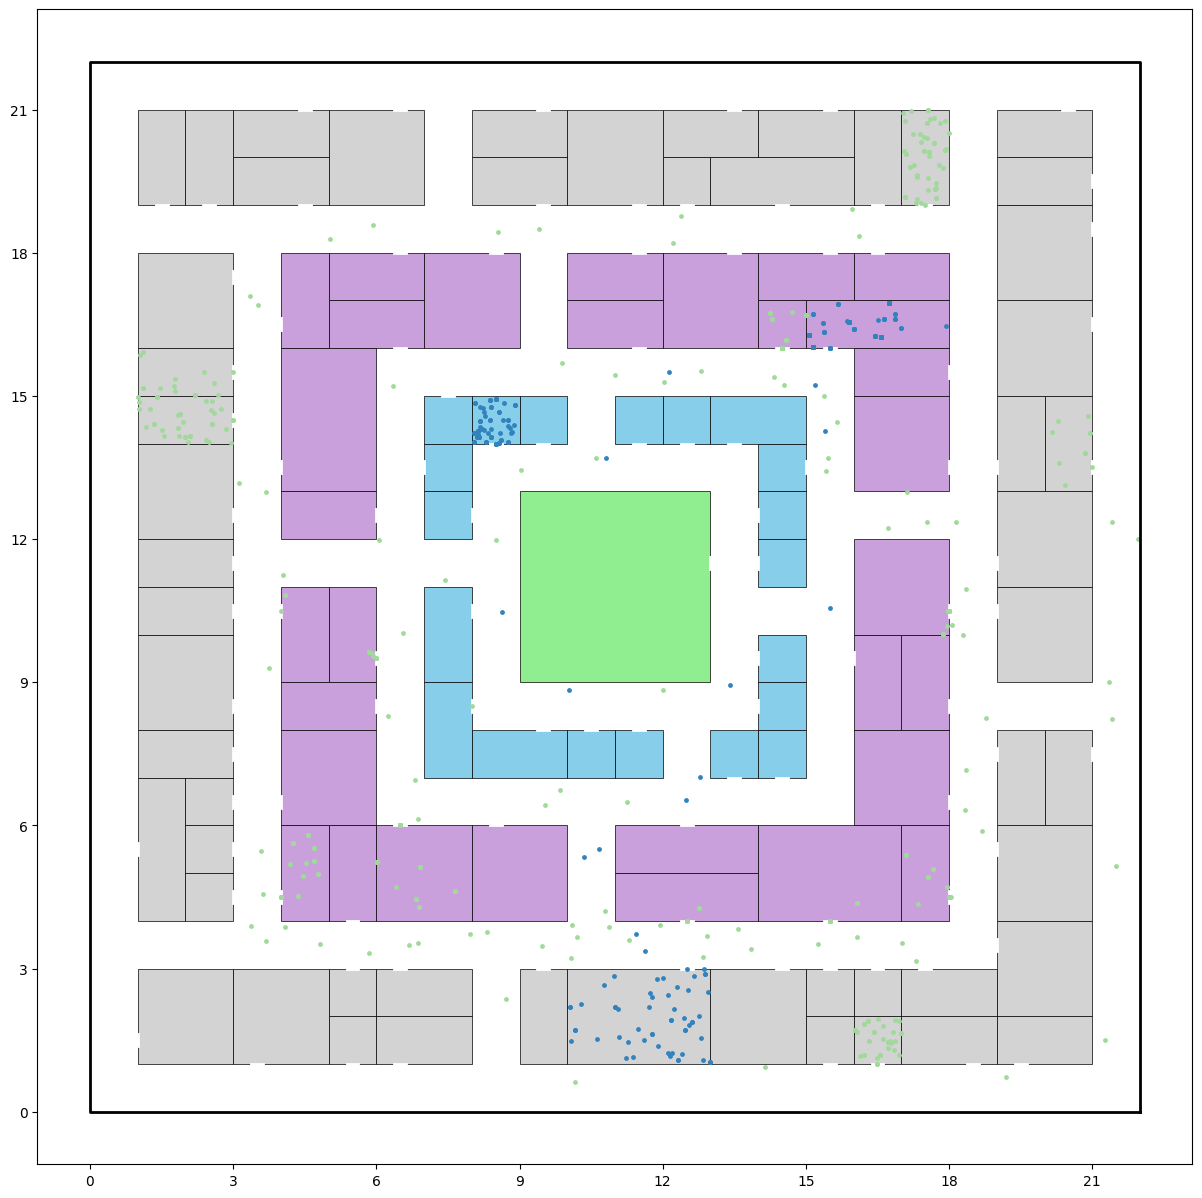

In [88]:
fig, ax = plt.subplots(figsize=(15, 15))
population.plot_population(ax)

#plt.savefig("garden-city-two-users.png")

In [130]:
population2 = Population(city)
population2.generate_agents(5)

for i, agent_id in enumerate(population2.roster):
    agent = population2.roster[agent_id]
    population.generate_trajectory(agent, T=40, seed=i+1)

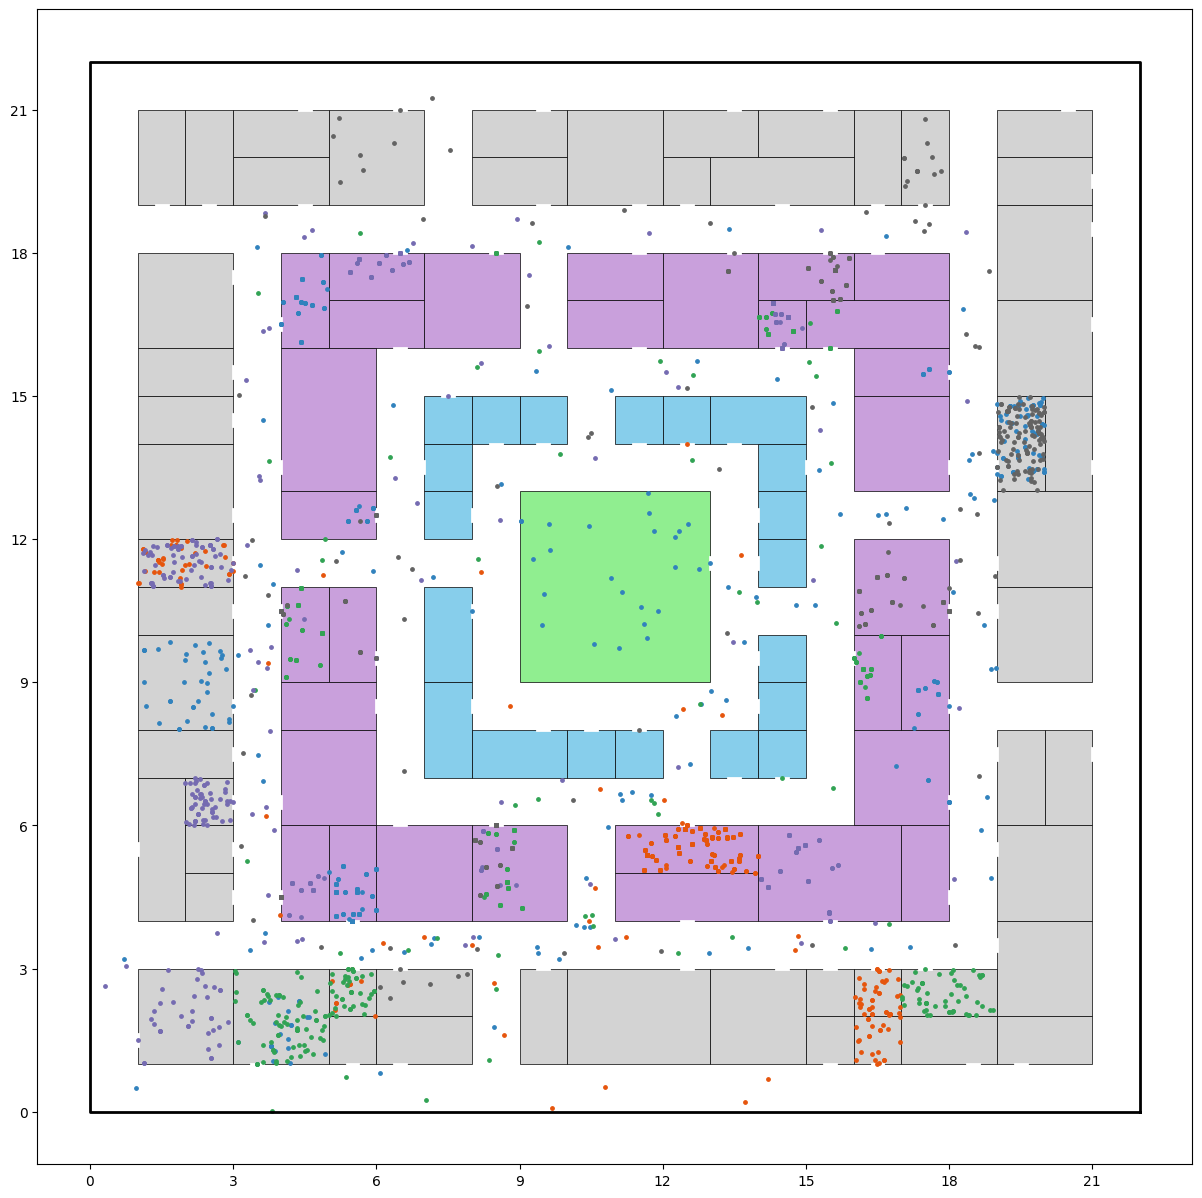

In [131]:
fig, ax = plt.subplots(figsize=(15, 15))

population2.plot_population(ax)

#agent = population2.roster['Agent3']
#agent.plot_traj(ax)

# Demonstration: Clustering Algorithms

In [15]:
# user-level stop table: 
def generate_stop_table(data, dbscan_df):
    """
    TODO: user id, ts, duration, centroid coord, max time gap, radius, etc.

    Returns
    -------
    TODO
    """
    num_clusters = sum(dbscan_df.cluster.unique() > -1)

    stop_table = []

    total_stop_time = 0

    for cid in range(num_clusters):
        cpings = dbscan_df[dbscan_df.cluster == cid]
        cdata = data.loc[cpings.index]
        duration = int((cdata.index.max() - cdata.index.min()) // 60)
        n = len(cdata)
        x_mean = np.mean(cdata['x'])
        y_mean = np.mean(cdata['y'])
        radius = np.sqrt(np.mean(np.sum((cdata[['x','y']].to_numpy() 
                                         - np.mean(cdata[['x','y']].to_numpy(), axis=0))**2, axis=1)))
        row = [duration, x_mean, y_mean, radius]
        stop_table += row

    return pd.DataFrame(stop_table)

def stop_statistics(data, dbscan_df):
    """
    TODO: user-level metrics: number of clusters, radius of gyration,
    time resolution param? 
    """
    num_clusters = sum(dbscan_df.cluster.unique() > -1)
    total_stop_time = 0

    for cid in range(num_clusters):
        cpings = dbscan_df[dbscan_df.cluster == cid]
        cdata = data.loc[cpings.index]
        duration = int((cdata.index.max() - cdata.index.min()) // 60)
        n = len(cdata)
        x_mean = np.mean(cdata['x'])
        y_mean = np.mean(cdata['y'])
        radius = np.sqrt(np.mean(np.sum((cdata[['x','y']].to_numpy() 
                                         - np.mean(cdata[['x','y']].to_numpy(), axis=0))**2, axis=1)))

        total_stop_time += duration

    return [num_clusters, total_stop_time]

In [89]:
start_time = [datetime(2024, 6, 1, hour=0, minute=0) + timedelta(minutes=60*t) for t in range(5)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*5  # in minutes

location = ['h-x13-y9'] * 1 +['h-x13-y11'] * 1 + ['r-x18-y10'] * 3

destination = pd.DataFrame({"unix_timestamp":unix_timestamp, "local_timestamp":start_time, "duration":duration, "location":location})
destination = condense_destinations(destination)

Angela = Agent("Angela",
               'h-x13-y9',
               'w-x18-y10',
               city,
               destination_diary=destination)

#Angela.destination_diary

population.add_agent(Angela)
population.generate_trajectory(Angela, seed=60, dt=0.25)

Angela.diary

,unix_timestamp,local_timestamp,duration,location
0,1.717200e+09,2024-06-01 00:00:15,60.0,h-x13-y9
1,1.717204e+09,2024-06-01 01:00:15,1.0,None
2,1.717204e+09,2024-06-01 01:01:15,59.0,h-x13-y11
3,1.717207e+09,2024-06-01 02:00:15,3.0,None
4,1.717207e+09,2024-06-01 02:03:15,177.0,r-x18-y10


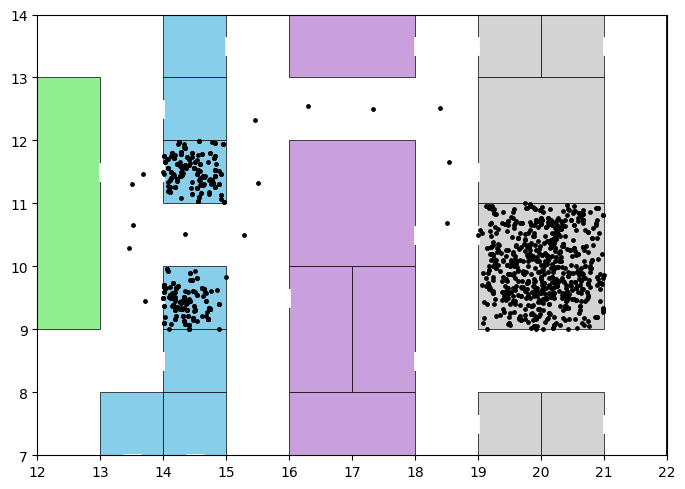

In [90]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(Angela.trajectory.x, Angela.trajectory.y, s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=True, zorder=1)

ax.set_xlim(12, 22)
ax.set_ylim(7, 14)

plt.tight_layout()
plt.show()

#plt.savefig("garden-city-one-user-full.png")

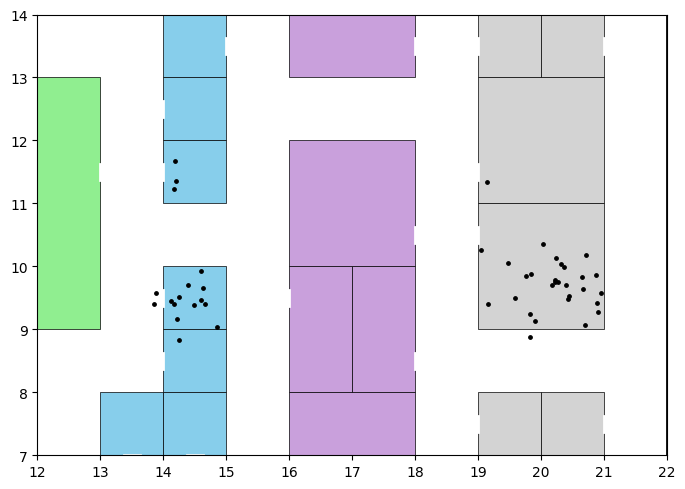

In [99]:
hawkes = [(2, 1/3, 4.6), (9, 1/4, 4.6)]
sparse_traj = mmod.sample_traj(Angela.trajectory, *hawkes[0], nu=5/15, seed=60)

fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(sparse_traj.x, sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=True, zorder=1)

ax.set_xlim(12, 22)
ax.set_ylim(7, 14)

plt.tight_layout()
plt.show()

#plt.savefig("garden-city-one-user-sparse.png")

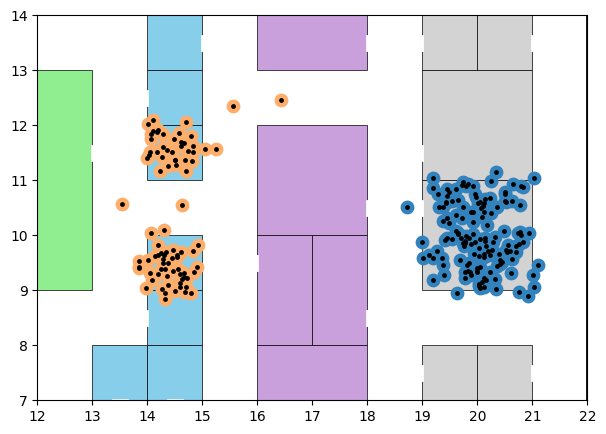

In [92]:
params = [(240, 2, 2), (60, 0.5, 3)]
seed = 60

sparse_traj = sparse_traj.set_index('unix_timestamp', drop=False)
dbscan_out = sd.temporal_dbscan(sparse_traj, *params[0])

#dbscan_out
#generate_stop_table(sparse_traj, dbscan_out)

fig, ax = plt.subplots(figsize=(9, 5))

num_clusters = sum(dbscan_out.cluster.unique() > -1)
for cid in range(num_clusters):
    cpings = dbscan_out[dbscan_out.cluster == cid]
    cdata = sparse_traj.loc[cpings.index]
    col = cm.tab20c(cid/(num_clusters+1))
    ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

ax.scatter(sparse_traj.x, sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=True, zorder=1)

ax.set_xlim(12, 22)
ax.set_ylim(7, 14)

plt.show()

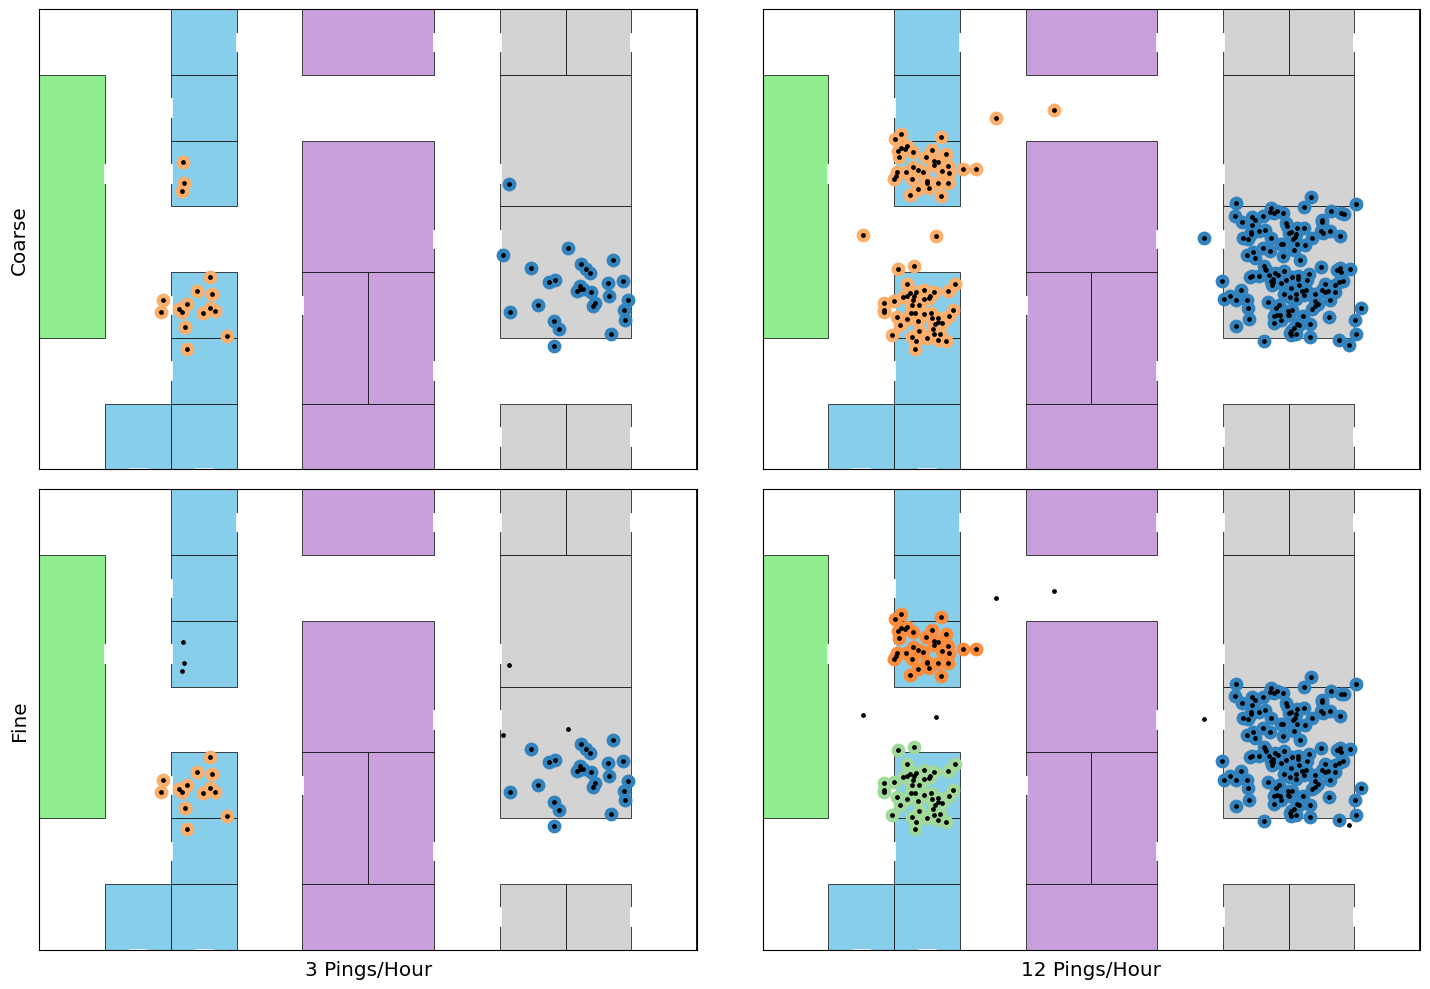

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
params = [(240, 2, 2), (60, 0.5, 3)]
hawkes = [(2, 1/3, 4.6), (9, 1/4, 4.6)]
seed = 60

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        df = mmod.sample_traj(Angela.trajectory, *hawkes[j], nu=5/15, seed=seed)
        df = df.set_index('unix_timestamp', drop=False)

        dbscan_out = sd.temporal_dbscan(df, *params[i])

        num_clusters = sum(dbscan_out.cluster.unique() > -1)
        for cid in range(num_clusters):
            cpings = dbscan_out[dbscan_out.cluster == cid]
            cdata = df.loc[cpings.index]
            col = cm.tab20c(cid/(num_clusters+1))
            ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

        ax.scatter(df.x, df.y, s=6, color='black', alpha=1, zorder=2)
        city.plot_city(ax, doors=True, address=True, zorder=1)

        ax.set_xlim(12, 22)
        ax.set_ylim(7, 14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

axes[0, 0].set_ylabel('Coarse', fontsize='x-large')
axes[1, 0].set_ylabel('Fine', fontsize='x-large')
axes[1, 0].set_xlabel('3 Pings/Hour', fontsize='x-large')
axes[1, 1].set_xlabel('12 Pings/Hour', fontsize='x-large')

plt.tight_layout()
plt.savefig("garden-city-stdbscan.png")
plt.show()

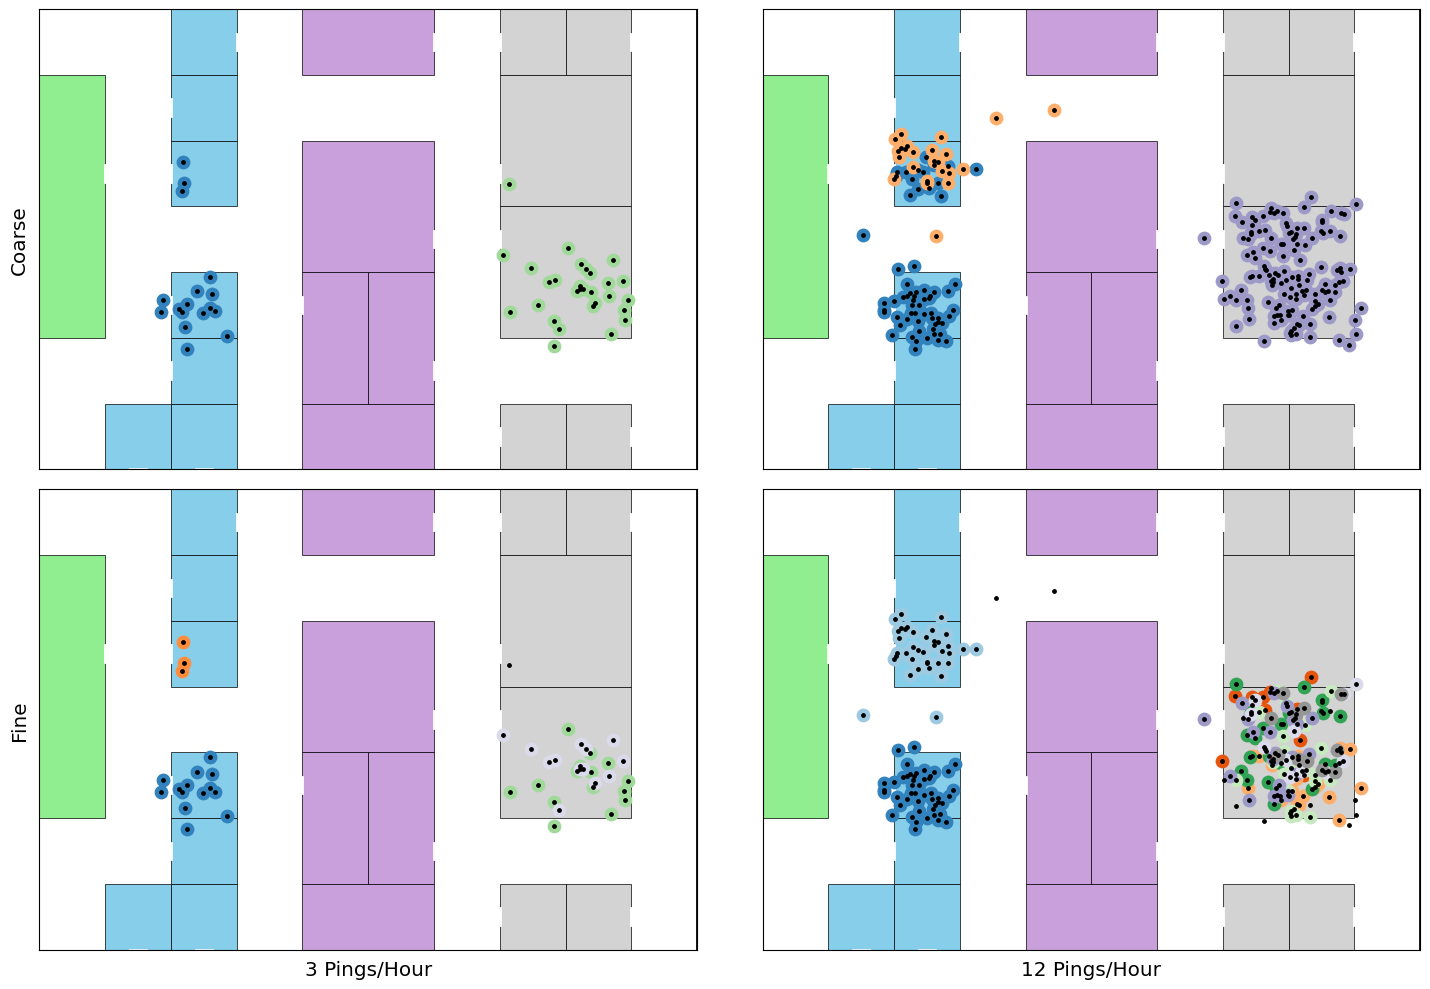

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
params = [(10, 120, 3), (10, 60, 2)]
hawkes = [(2, 1/3, 4.6), (9, 1/4, 4.6)]
seed = 60

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        df = mmod.sample_traj(Angela.trajectory, *hawkes[j], nu=5/15, seed=seed)
        df = df.set_index('unix_timestamp', drop=False)

        lachesis_out = sd.lachesis_patches(df, *params[i])

        for idx, data in enumerate(lachesis_out):
            col = cm.tab20c(idx/len(lachesis_out))
            ax.scatter(data.x, data.y, s=80, color=col, alpha=1, zorder=2)

        ax.scatter(df.x, df.y, s=6, color='black', alpha=1, zorder=2)
        city.plot_city(ax, doors=True, address=True, zorder=1)

        ax.set_xlim(12, 22)
        ax.set_ylim(7, 14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

axes[0, 0].set_ylabel('Coarse', fontsize='x-large')
axes[1, 0].set_ylabel('Fine', fontsize='x-large')
axes[1, 0].set_xlabel('3 Pings/Hour', fontsize='x-large')
axes[1, 1].set_xlabel('12 Pings/Hour', fontsize='x-large')

plt.tight_layout()
plt.savefig("garden-city-lachesis.png")
plt.show()

Animation of pre-sampled trajectory for one users

In [98]:
# from matplotlib.animation import FuncAnimation, PillowWriter

# fig, ax = plt.subplots(figsize=(15, 15))

# city.plot_city(ax, doors=True, address=True, zorder=1)

# line, = ax.plot([], [], color='blue', alpha=0.1)
# scatter = ax.scatter([], [], s=8, color='black', alpha=0.5)
# time_text = ax.text(0.5, 0.975, '', transform=ax.transAxes)

# fade_length = 60  # Adjust this to control the length of the fade

# def update(i):
#     if i < fade_length:
#         current_fade_length = i + 1
#     else:
#         current_fade_length = fade_length
#     alphas = np.array([np.exp(-0.5*x) for x in range(current_fade_length)][::-1])

#     line.set_data(Angela.trajectory['x'][:i], Angela.trajectory['y'][:i])
#     scatter.set_offsets(Angela.trajectory[['x', 'y']][:i])
#     scatter.set_alpha(np.pad(alphas, (i + 1 - current_fade_length, 0), 'constant'))
#     time_text.set_text(Angela.trajectory['local_timestamp'][i].strftime('%Y-%m-%d %H:%M:%S'))
#     return line, scatter

# anim = FuncAnimation(fig, update, frames=len(Angela.trajectory), interval=50, blit=True)
# anim.save('garden-city-traj-animation.gif', writer=PillowWriter(fps=20))
# plt.close(fig)